In [1]:
# hide
# all_slow

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Grid Generation Tutorial

> A basic introduction to Geospatial Grids

## Basic Usage
Creating a grid from a geojson file

In [5]:
# hide
import warnings

from IPython.display import display

warnings.filterwarnings("ignore")

### Import `geopandas` and the `geowrangler.grids` module

In [6]:
import geopandas as gpd
import pandas as pd

from geowrangler import grids

In [7]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

### Load a sample geojson file into pandas 


In our case, we are loading the Region 3 (Central Luzon Administrative Region) of the Philippines.

In [8]:
region3_gdf = gpd.read_file("../data/region3_admin.geojson")

This geopandas dataframe has the size: 

In [9]:
# hide_input
print(f"length of region3_gdf: {len(region3_gdf)} row(s)")

length of region3_gdf: 1 row(s)


In [10]:
display(region3_gdf)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."


Show the original plot

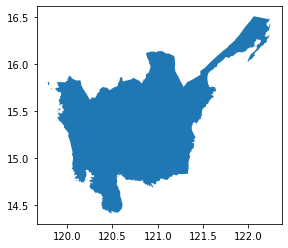

In [11]:
import matplotlib.pyplot as plt

ax = region3_gdf.plot(ax=plt.axes())

In [12]:
region3_gdf.crs  # CRS info

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
aoi_total_bounds = region3_gdf.total_bounds
aoi_total_bounds

array([119.7858332,  14.4075257, 122.2429921,  16.5092548])

## Square Grid Generator
### Creating Grids

Create a grid generator with a size of `5,000` m. 
The units of the grid size are dependent on the projection parameter  
of the grid generator. In this case, the [default is  `EPSG:3857`](https://epsg.io/3857).

In [14]:
grids.SquareGridGenerator?

Init signature:
grids.SquareGridGenerator(
    cell_size: float,
    grid_projection: str = 'EPSG:3857',
    boundary: Union[geowrangler.grids.SquareGridBoundary, List[float]] = None,
)
Docstring:      <no docstring>
File:           ~/geowrangler/geowrangler/grids.py
Type:           type
Subclasses:     


In [15]:
grid_generator5k = grids.SquareGridGenerator(5_000)  # 5 km x 5 km square cells

Generate square grids
> Notice the time taken to grid the multi polygon at 5K resolution


In [16]:
%%time
# slow
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)

CPU times: user 857 ms, sys: 9.23 ms, total: 867 ms
Wall time: 864 ms


<AxesSubplot:>

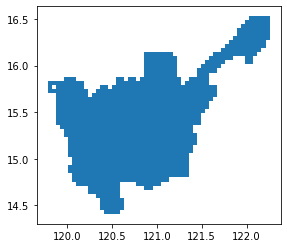

In [17]:
grid_gdf5k.plot()

Show gridded version of sample geojson file at 5K resolution 

In [18]:
# hide_input
# no_test
print(f"length of grid_gdf5k: {len(grid_gdf5k)} row(s)")

length of grid_gdf5k: 1074 row(s)


In [19]:
# hide
# slow
assert len(grid_gdf5k) == 1074

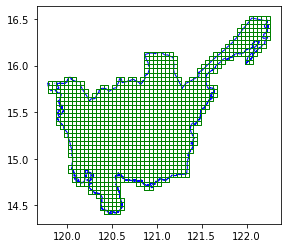

In [20]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k.plot(ax=ax, facecolor="none", edgecolor="green")

In addition to the grid cells, there are 2 extra columns `x` and `y` when combined are unique per grid. It can also tell us which grids are adjacent to each other. 

In [21]:
# slow
grid_gdf5k.head()

,x,y,geometry
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755..."
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755..."
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755..."
3,2,24,"POLYGON ((119.87566 15.44910, 119.92058 15.449..."
4,2,25,"POLYGON ((119.87566 15.49239, 119.92058 15.492..."


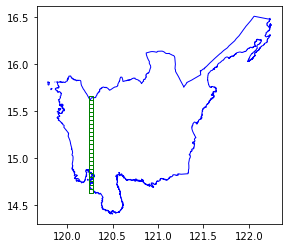

In [22]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k[grid_gdf5k["x"] == 10].plot(ax=ax, facecolor="none", edgecolor="green")

### Gridding at a coarser resolution
Let's try the same process but with a bigger grid (15K)

In [23]:
grid_generator15k = grids.SquareGridGenerator(15_000)  # 15 km x 15 km grids

Generate square grids
> Notice the time taken to grid the multi polygon at 15K resolution (compared to 5K resolution)


In [24]:
%%time
grid_gdf15k = grid_generator15k.generate_grid(region3_gdf)

CPU times: user 812 ms, sys: 0 ns, total: 812 ms
Wall time: 811 ms


<AxesSubplot:>

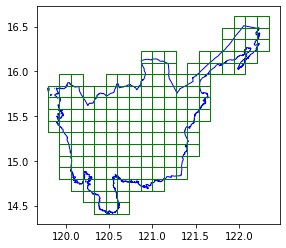

In [25]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")

Show gridded version of sample geojson file at 15K resolution 

In [26]:
# hide_input
print(f"length of grid_gdf15k: {len(grid_gdf15k)} row(s)")

length of grid_gdf15k: 154 row(s)


In [27]:
# hide
assert len(grid_gdf15k) == 154

### Reusing boundaries
If you have 2 polygons that are far from each other but wish to have them follow the reference same reference `x` and `y`, you can use pass in custom boudaries. 

Let's load some grids that are from each other

In [28]:
cell1 = grid_gdf15k.head(1)
cell2 = grid_gdf15k.tail(1)

In [29]:
pd.concat([cell1, cell2])

,x,y,geometry
0,2,2,"POLYGON ((120.05533 14.66839, 120.19008 14.668..."
153,18,16,"POLYGON ((122.21128 16.48548, 122.34603 16.485..."


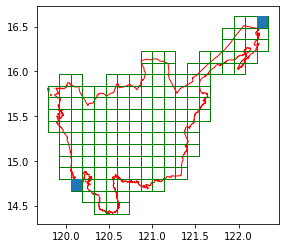

In [30]:
ax = region3_gdf.plot(facecolor="none", edgecolor="red")
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")
ax = pd.concat([cell1, cell2]).plot(ax=ax)

In [31]:
grid_generator1k = grids.SquareGridGenerator(1_000, boundary=aoi_total_bounds)

In [32]:
%%time
gridcell1 = grid_generator1k.generate_grid(cell1)

CPU times: user 40.6 ms, sys: 0 ns, total: 40.6 ms
Wall time: 38.3 ms


In [33]:
len(gridcell1)

272

In [34]:
gridcell1.head()

,x,y,geometry
0,29,30,"POLYGON ((120.04634 14.66839, 120.05533 14.668..."
1,29,31,"POLYGON ((120.04634 14.67708, 120.05533 14.677..."
2,29,32,"POLYGON ((120.04634 14.68577, 120.05533 14.685..."
3,29,33,"POLYGON ((120.04634 14.69446, 120.05533 14.694..."
4,29,34,"POLYGON ((120.04634 14.70315, 120.05533 14.703..."


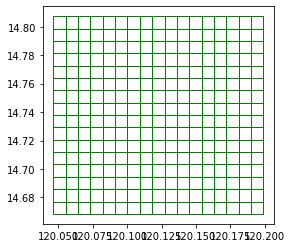

In [35]:
ax = gridcell1.plot(facecolor="none", edgecolor="green")

In [36]:
%%time
gridcell2 = grid_generator1k.generate_grid(cell2)

CPU times: user 41.9 ms, sys: 226 µs, total: 42.1 ms
Wall time: 39.5 ms


In [37]:
len(gridcell2)

20

In [38]:
gridcell2.head()

,x,y,geometry
0,269,239,"POLYGON ((122.20230 16.47686, 122.21128 16.476..."
1,269,240,"POLYGON ((122.20230 16.48548, 122.21128 16.485..."
2,269,241,"POLYGON ((122.20230 16.49409, 122.21128 16.494..."
3,269,242,"POLYGON ((122.20230 16.50270, 122.21128 16.502..."
4,270,239,"POLYGON ((122.21128 16.47686, 122.22027 16.476..."


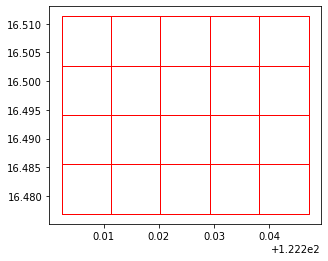

In [39]:
ax = gridcell2.plot(facecolor="none", edgecolor="red")

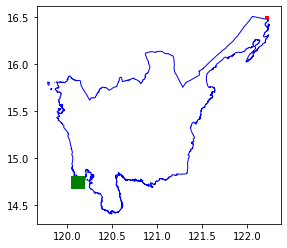

In [40]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = gridcell1.plot(ax=ax, color="green")
ax = gridcell2.plot(ax=ax, color="red")

## Generating grids for multiple distant areas
If you are using AOIs that are vary far from each other, Grid Generator already optmizes the implementation for you


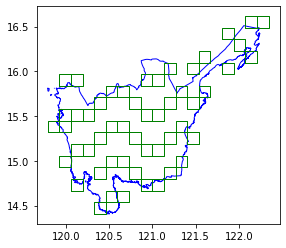

In [41]:
sparse_aois = grid_gdf15k.iloc[
    0:1000:3,
]  # Get areas that far from each other
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_aois.plot(ax=ax, facecolor="none", edgecolor="green")

In [42]:
sparse_grid = grid_generator1k.generate_grid(sparse_aois)

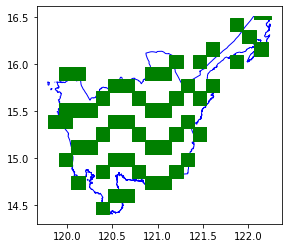

In [43]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_grid.plot(ax=ax, facecolor="none", edgecolor="green")

It is a bit hard to see the grids so, we get a subset to verify.

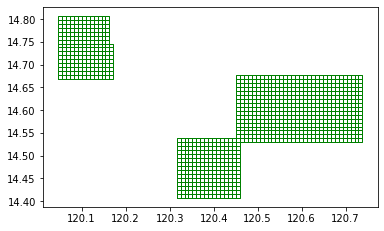

In [44]:
ax = sparse_grid.head(1000).plot(facecolor="none", edgecolor="green")

## H3 Grid Generator
### Generating grids
Let us generate grids of resolution 5. To learn more about the different resolution, visit: https://h3geo.org/docs/core-library/restable/

In [45]:
h3_generator = grids.H3GridGenerator(resolution=5)

In [46]:
%%time
h3_5_gdf = h3_generator.generate_grid(region3_gdf)

CPU times: user 4.16 s, sys: 32.7 ms, total: 4.19 s
Wall time: 4.19 s


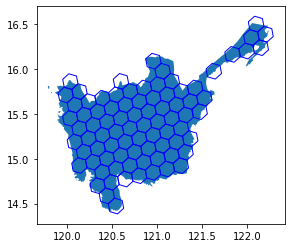

In [47]:
ax = region3_gdf.plot(aspect="equal")
ax = h3_5_gdf.plot(ax=ax, facecolor="none", edgecolor="blue", aspect="equal")

### Not exporting geometry
If you do not plan to use use geometry, you can pass `return_geometry=False` to just get a normal pandas DataFrame with the ids.

In [48]:
h3_generator_no_geom = grids.H3GridGenerator(resolution=5, return_geometry=False)

In [49]:
%%time
h3_region3_no_geom = h3_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 4.77 s, sys: 23.6 ms, total: 4.79 s
Wall time: 4.79 s


In [50]:
len(h3_region3_no_geom)

84

In [51]:
h3_region3_no_geom.head()

,hex_id
0,85694177fffffff
1,85694027fffffff
2,85696a7bfffffff
3,85694157fffffff
4,85694ccffffffff


## Bing Tile Grid Generator
### Generating grids
Let us generate grids of zoom_level 12. To learn more about the different resolution, visit: https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system

In [14]:
bing_tile_grid_generator = grids.BingTileGridGenerator(12)

In [15]:
%%time
# slow
bing_tile_gdf = bing_tile_grid_generator.generate_grid(region3_gdf)

CPU times: user 12.9 s, sys: 0 ns, total: 12.9 s
Wall time: 12.9 s


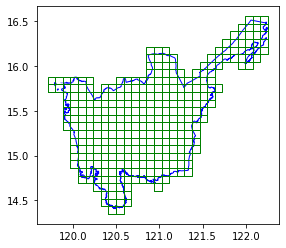

In [16]:
# no_test
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = bing_tile_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

### Not exporting geometry

If you do not plan to use use geometry, you can pass return_geometry=False to just get a normal pandas DataFrame with the ids.


In [17]:
bing_tile_grid_generator_no_geom = grids.BingTileGridGenerator(
    12, return_geometry=False
)

In [18]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 14.3 s, sys: 4.32 ms, total: 14.3 s
Wall time: 14.3 s


In [19]:
# no_test
bing_region3_keys.head()

,quadkey
0,132303030330
1,132303030331
2,132303030313
3,132303012302
4,132303012031


### Converting quadkey to x,y format

If you need to convert the quadkey to x,y format, you can pass add_xy_cols=True to add the x and y columns to the returned dataframe. 

In [25]:
bing_tile_grid_generator_add_xy = grids.BingTileGridGenerator(
    12, return_geometry=True, add_xy_cols=True
)

In [26]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_add_xy.generate_grid(region3_gdf)

CPU times: user 12.3 s, sys: 18.5 ms, total: 12.4 s
Wall time: 12.4 s


In [27]:
# no_test
bing_region3_keys.head()

,quadkey,x,y,geometry
0,132303030330,3414,1878,"POLYGON ((120.05859 14.68988, 120.05859 14.774..."
1,132303030331,3415,1878,"POLYGON ((120.14648 14.68988, 120.14648 14.774..."
2,132303030313,3415,1877,"POLYGON ((120.14648 14.77488, 120.14648 14.859..."
3,132303012302,3412,1869,"POLYGON ((119.88281 15.45368, 119.88281 15.538..."
4,132303012031,3411,1866,"POLYGON ((119.79492 15.70766, 119.79492 15.792..."


Hover over the interactive map to see that the extracted x and y coordinates are adjacent.

In [28]:
# no_test
bing_region3_keys.explore()